In [5]:
from qiskit import QuantumRegister, ClassicalRegister, BasicAer
from qiskit import QuantumCircuit, Aer
from qiskit import execute 

# Create one 4 qubit QuantumRegister to hold the 3 random variables and the ancilla qubit, 
# and a 3 bit ClassicalRegister to hold the sampled values 

qreg = QuantumRegister(5, 'qreg')
creg = ClassicalRegister(3, 'creg')

circuit = QuantumCircuit(qreg, creg, name='circuit')

In [6]:
# To encode the probabilities, let's set up a function that converts them to amplitudes 

import numpy as np 

def probToAngle(prob):
    return 2*np.arcsin(np.sqrt(prob))

In [7]:
# Setting up our qubits 
"""
    Set the probabilities of the variables 
    
    // NOTE: What about the weights of the Sum Nodes? 
     
"""

x = 0.8
y = 0.3
sum_weight = 0.4

not_x = 1 - x
not_y = 1 -y
not_sum_weight = 0.6

# PREPARING the Circuit
circuit.u3(probToAngle(x), 0, 0, qreg[0])
circuit.u3(probToAngle(y), 0, 0, qreg[1])
circuit.u3(probToAngle(sum_weight), 0, 0, qreg[2])
circuit.u3(probToAngle(not_sum_weight), 0, 0, qreg[3])

circuit.x(qreg[2])
circuit.x(qreg[3])

circuit.x(qreg[0])

circuit.ccx(qreg[0], qreg[1], qreg[2])

circuit.x(qreg[0])
circuit.x(qreg[1])

circuit.ccx(qreg[0], qreg[1], qreg[3])

circuit.ccx(qreg[2], qreg[3], qreg[4])



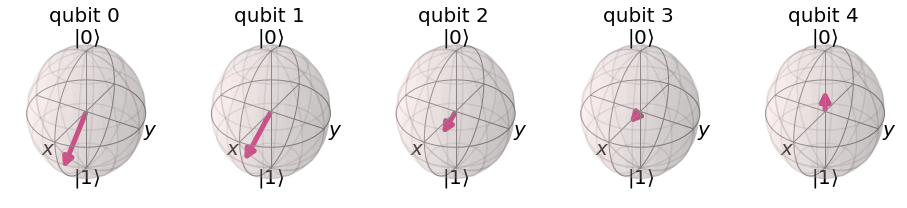

In [8]:
"""
    Plotting the qubits 
"""
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector


backend_statevector = BasicAer.get_backend('statevector_simulator')

job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

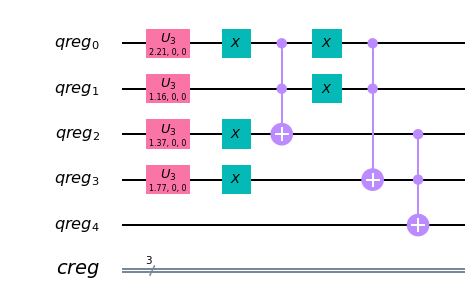

In [9]:
circuit.draw(output="mpl")


In [ ]:
# Functions 
pi = np.pi

def oracle(circ):
    """
    Implements an oracle that flips the sign of states that contain x and y 
    """
    circ.u3(pi, pi, 1, qreg[0])
    circ.u3(pi, pi, 1, qreg[0])    
    
    circ.u3(pi, pi, 1, qreg[1])
    circ.u3(pi, pi, 1, qreg[1])
    return circ


def u_gate(circ):
    """
    Implements the U gate that flips states about the average amplitude.
    """
    # Implements the quantum circuit that converts ψ -> |000...0>
    # circ.u3(-1*probToAngle(x), 0, 0, qreg[0])
    # circ.u3(-1*probToAngle(y), 0, 0, qreg[1])
    # circ.u3(-1*probToAngle(V1_0), 0, 0, qreg[2])

    # Flipping the |000...0> state using a triple controlled Z gate condtioned on P, E and H, 
    # and applied to the ancilla
    circ.x(qreg)
    circ.cu1(pi/4, qreg[0], qreg[3])
    circ.cx(qreg[0], qreg[1])
    circ.cu1(-pi/4, qreg[1], qreg[3])
    circ.cx(qreg[0], qreg[1])
    circ.cu1(pi/4, qreg[1], qreg[3])
    circ.cx(qreg[1], qreg[2])
    circ.cu1(-pi/4, qreg[2], qreg[3])
    circ.cx(qreg[0], qreg[2])
    circ.cu1(pi/4, qreg[2], qreg[3])
    circ.cx(qreg[1], qreg[2])
    circ.cu1(-pi/4, qreg[2], qreg[3])
    circ.cx(qreg[0], qreg[2])
    circ.cu1(pi/4, qreg[2], qreg[3])
    circ.x(qreg)

    # Implements the quantum circuit that converts |000...0> -> ψ 
    # circ.u3(probToAngle(H_1), 0, 0, qreg[0])
    # circ.u3(probToAngle(V0_0), 0, 0, qreg[1])
    # circ.u3(probToAngle(V1_0), 0, 0, qreg[2])

    return circ


# Apply oracle and U gate twice
circuit = oracle(circuit)
circuit = u_gate(circuit)
circuit = oracle(circuit)
circuit = u_gate(circuit)
circuit.x(qreg[0])


backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))



In [ ]:
# Measure H and rotate V0 
circuit.measure(qreg[0], creg[0])
# circuit.u3(probToAngle(V0_1) - probToAngle(V0_0), 0, 0, qreg[1])

backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

In [ ]:
# Sample by measuring the rest of the qubits
circuit.measure(qreg[1], creg[1])
circuit.measure(qreg[2], creg[2])

backend_statevector = BasicAer.get_backend('statevector_simulator')
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

In [ ]:
# Get backend from Aer provider
backend = Aer.get_backend('qasm_simulator')

# Run job many times to get multiple samples
samples_list = []
n_samples = 1000

for i in range(n_samples):
    job = execute(circuit, backend=backend, shots=1)
    result = list(job.result().get_counts(circuit).keys())[0]
    if result[2] == '0':
        samples_list.append(result)

# Printing the number of useful samples and percentage of samples rejected
print()
print(n_samples, 'samples drawn:', len(samples_list), 'samples accepted,', n_samples-len(samples_list), 'samples rejected.' )
print('Percentage of samples rejected: ', 100*(1 - (len(samples_list)/n_samples)), '%')

# Computing P(H = 0| P = 1)
p_H = 0

for i in samples_list:
    if i[0] == '1':
        p_H += 1

p_H /= len(samples_list)

print('P(V1 = 0| H = 1) =', p_H)
print()